<h1 style="color:#ff69b4"> Metrics Evaluation </h1>

## Libraries and Packages

In [1]:
#! pip install 
#pip install lpips


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torch
import os
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.models import inception_v3
from torchvision.utils import save_image
from PIL import Image
#import metrics
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from sklearn.metrics import mean_absolute_error as MAE
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips




## Img Selection 


### Less Complex Images

In [56]:
# load two png images 1 and 2 
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)
    return image

img1= load_image('/home/nbelloula/Images/Imgs/image1.png')
img2= load_image('/home/nbelloula/Images/Imgs/image2.png')
img190= load_image('/home/nbelloula/Images/Imgs/img290.png')
img_triB= load_image('/home/nbelloula/Images/Imgs/img_triB.png')
img_triB90= load_image('/home/nbelloula/Images/Imgs/img_triB90.png')
img_triW= load_image('/home/nbelloula/Images/Imgs/img_triW.png')
img_moon= load_image('/home/nbelloula/Images/Imgs/moon.png')
img_triShift= load_image('/home/nbelloula/Images/Imgs/img_triShift.png')
img_triR= load_image('/home/nbelloula/Images/Imgs/img_triR.png')
print(img1.shape, img2.shape, img_moon.shape, img_triB.shape, img_triB90.shape, img_triW.shape, img_triShift.shape)

# #dispmlay images
# plt.imshow(img1[0].permute(1, 2, 0).numpy())
# plt.imshow(img2[0].permute(1, 2, 0).numpy())
# plt.imshow(img_moon[0].permute(1, 2, 0).numpy())

# imshow = T.ToPILImage()
# imshow(img1[0]).show()
# imshow(img2[0]).show()
# imshow(img_moon[0]).show()

torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299])


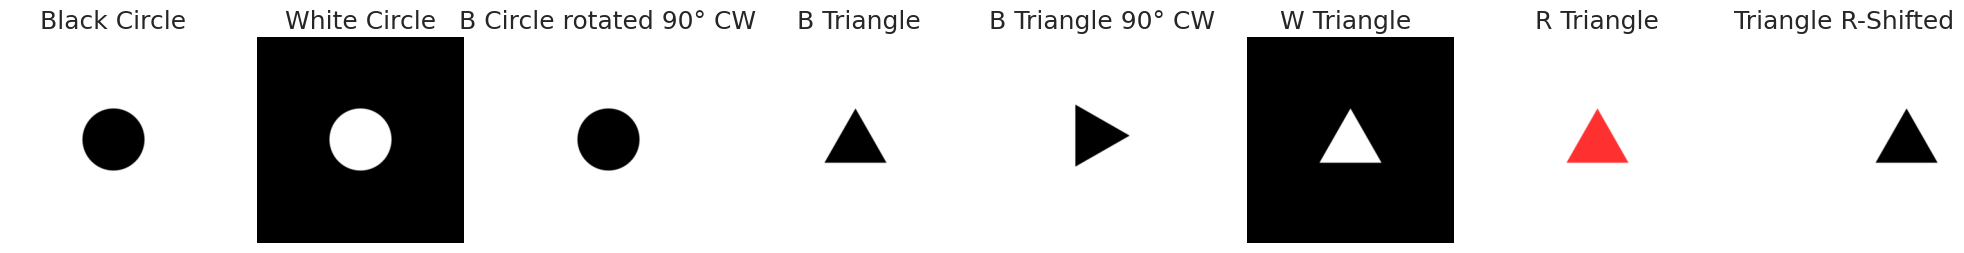

In [150]:
# Display the images in a grid
def display_images_grid(images, titles=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(25, 25))
    for i, img in enumerate(images):
        axes[i].imshow((img.squeeze(0).permute(1, 2, 0).numpy() + 1) / 2)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.show()

# Display the images
display_images_grid([img1, img2, img190, img_triB, img_triB90, img_triW, img_triR, img_triShift], 
                    titles=['Black Circle', 'White Circle', 'B Circle rotated 90° CW', ' B Triangle', 'B Triangle 90° CW', 'W Triangle ','R Triangle', 'Triangle R-Shifted'])

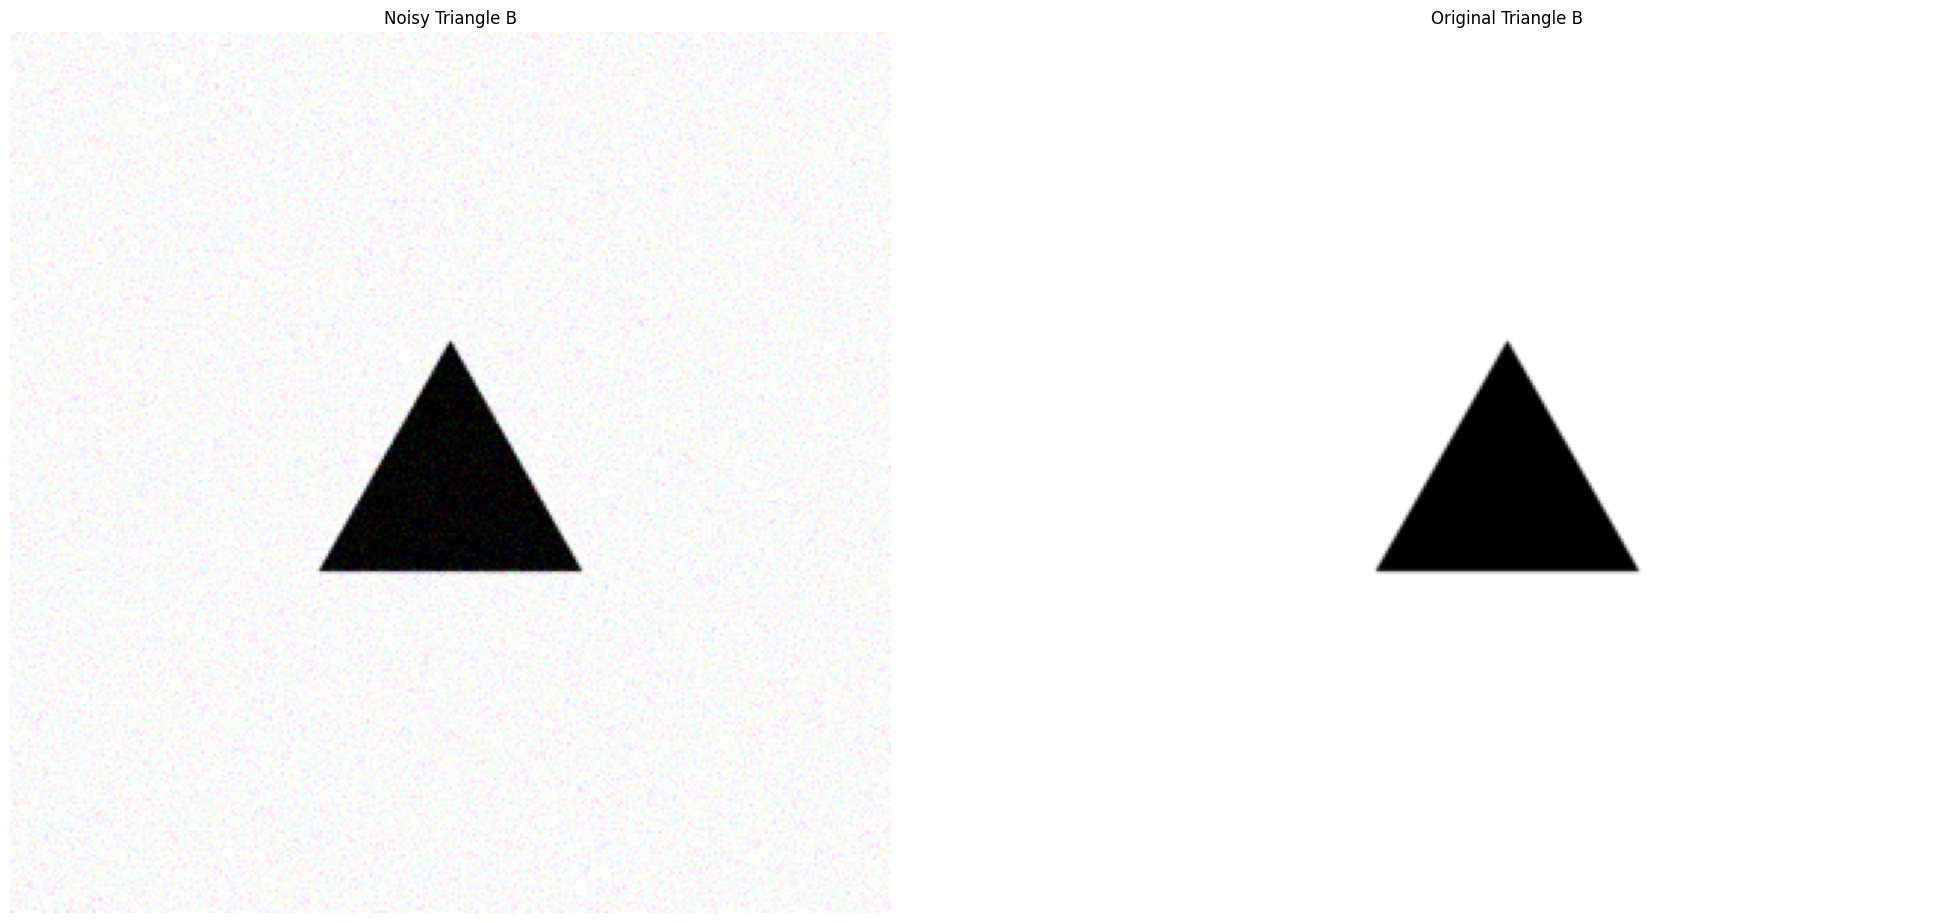

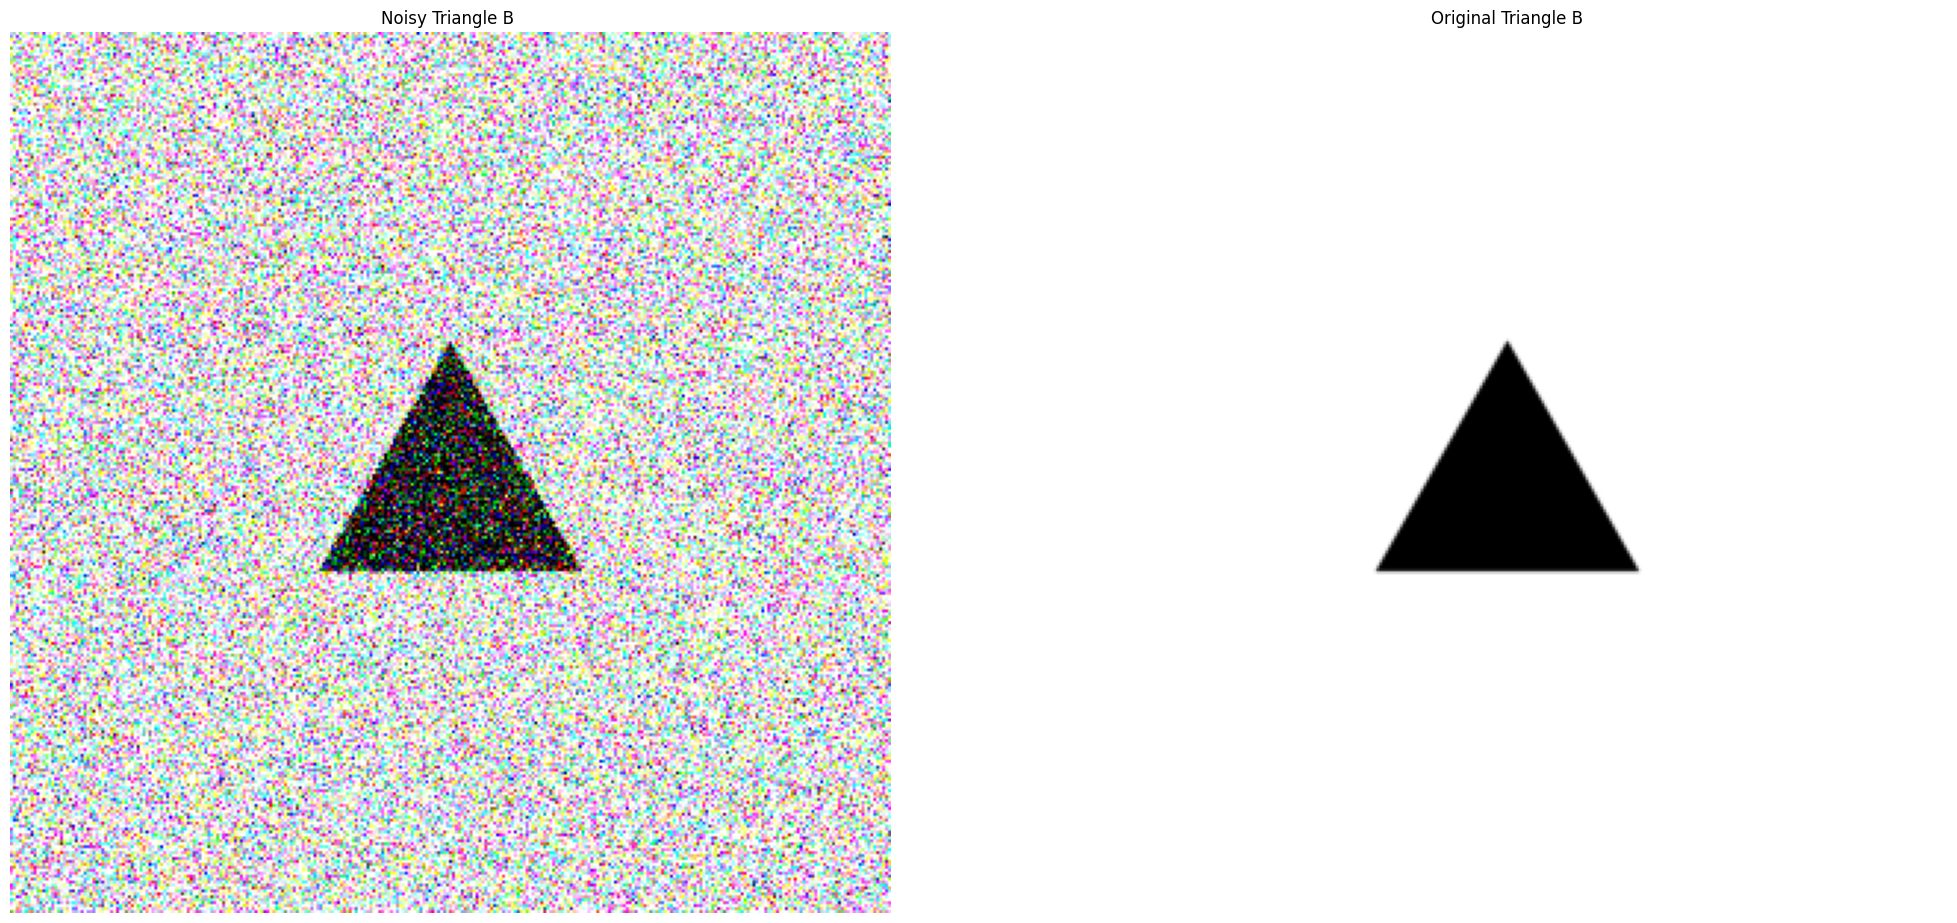

In [ ]:
#apply noise to img1 and img2
def add_noise(image, noise_factor=0.1): #0.1
    noise = torch.randn_like(image) * noise_factor
    noisy_image = image + noise
    return torch.clamp(noisy_image, -1, 1)

noisy1_img_triB = add_noise(img_triB, noise_factor=0.1)
noisy2_img_triB = add_noise(img_triB, noise_factor=0.9)

#display noisy image
display_images_grid([noisy1_img_triB, img_triB], titles=['Noisy Triangle B','Original Triangle B'])
display_images_grid([noisy2_img_triB, img_triB], titles=['Noisy Triangle B ','Original Triangle B'])

#blurr

### How the comparaison works ? 
Adding text soon !

## Metrics

### PSNR

In [153]:
# PSNR Function
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [ ]:
#Calculate PSNR
img1_self_psnr= calculate_psnr(img1[0].permute(1, 2, 0), img1[0].permute(1, 2, 0))
print(f"PSNR of black circle img with itself: {img1_self_psnr:.2f} dB")

#Psnr circle 
img290_psnr=PSNR(img190[0].permute(1, 2, 0).numpy(), img1[0].permute(1, 2, 0).numpy())
print(f"PSNR between circles one rotated 90 clock wise: {img290_psnr:.2f} dB")

#PSNR img1 and img2
img1_psnr=PSNR(img1[0].permute(1, 2, 0).numpy(), img2[0].permute(1, 2, 0).numpy())
print(f"PSNR between black circle and white circle: {img1_psnr:.2f} dB")

#PSNR same background but different color of the shape 
img_tri_RB=PSNR(img_triB[0].permute(1, 2, 0).numpy(), img_triR[0].permute(1, 2, 0).numpy())
print(f"PSNR between same bakchround & triangular shape but different color: {img_tri_RB:.2f} dB")

#Psnr same shape rotated
img_triB_psnr=PSNR(img_triB[0].permute(1, 2, 0).numpy(), img_triB90[0].permute(1, 2, 0).numpy())
print(f"PSNR between same triangular shape & color but rotated 90° clock-wise: {img_triB_psnr:.2f} dB")

#Psnr of same shape but shifted 
img_triShift_psnr=PSNR(img_triB[0].permute(1, 2, 0).numpy(), img_triShift[0].permute(1, 2, 0).numpy())
print(f"PSNR between same triangular shape but shifted to right: {img_triShift_psnr:.2f} dB")


#PSNR with noisy img
noisy_img_triB_psnr=PSNR(noisy1_img_triB[0].permute(1, 2, 0).numpy(), img_triB[0].permute(1, 2, 0).numpy())
print(f"PSNR between low noise triangle B and original triangle B: {noisy_img_triB_psnr:.2f} dB")

noisy2_img_triB_psnr=PSNR(noisy2_img_triB[0].permute(1, 2, 0).numpy(), img_triB[0].permute(1, 2, 0).numpy())
print(f"PSNR between high noise triangle B and original triangle B: {noisy2_img_triB_psnr:.2f} dB")



PSNR of black circle img with itself: inf dB
PSNR between circles one rotated 90 clock wise: inf dB
PSNR between black circle and white circle: 0.01 dB
PSNR between same bakchround & triangular shape but different color: 18.60 dB
PSNR between same triangular shape & color but rotated 90° clock-wise: 15.26 dB
PSNR between same triangular shape but shifted to right: 11.12 dB
PSNR between low noise triangle B and original triangle B: 28.97 dB
PSNR between high noise triangle B and original triangle B: 10.13 dB


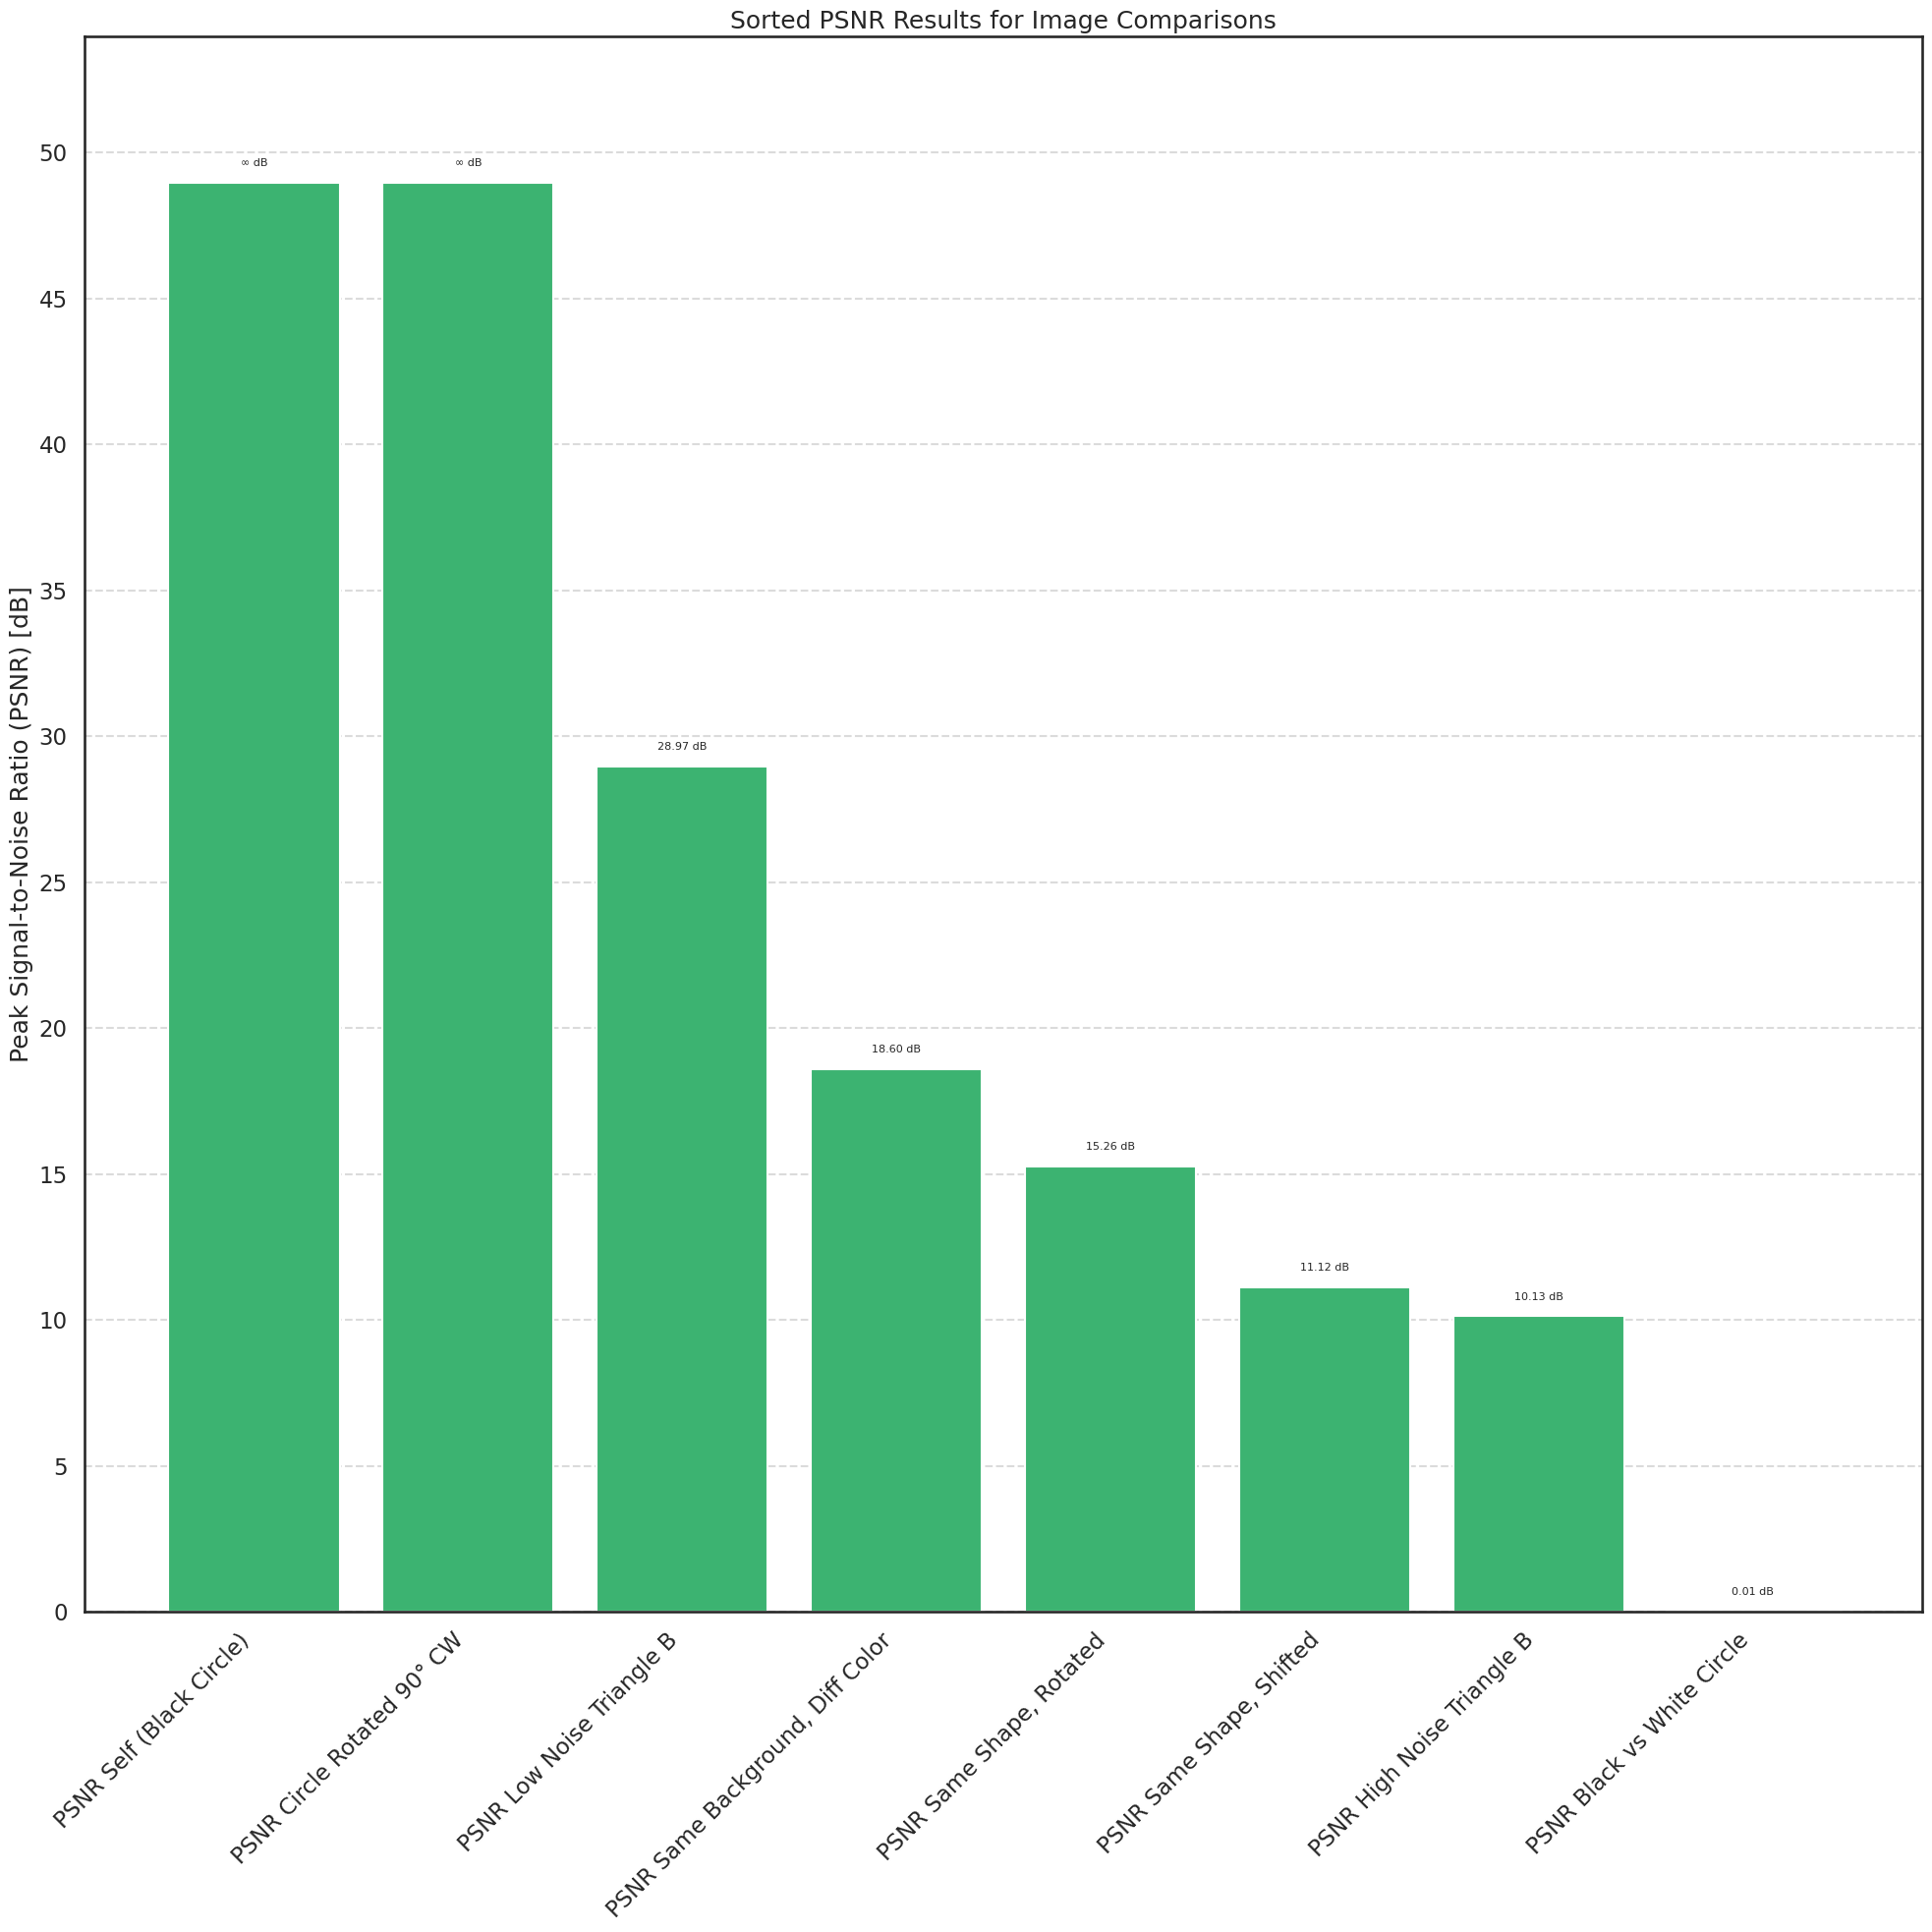

In [155]:
#Display PSNR results
#  

import matplotlib.pyplot as plt
import numpy as np
import math

def display_psnr_results(psnr_results):
    # Replace any infinite values with max finite + 20
    finite_values = [v for v in psnr_results.values() if math.isfinite(v)]
    if finite_values:
        max_finite = max(finite_values)
    else:
        max_finite = 0
    processed_results = {
        k: (max_finite + 20 if not math.isfinite(v) else v)
        for k, v in psnr_results.items()
    }

    # Sort by PSNR descending
    sorted_results = sorted(processed_results.items(), key=lambda x: x[1], reverse=True)
    names, values = zip(*sorted_results)

    # Plot
    plt.figure(figsize=(20,20))
    bars = plt.bar(names, values, color='mediumseagreen')

    # Annotate
    for bar, value in zip(bars, values):
        label = "∞" if value == max_finite + 20 else f"{value:.2f}"
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.5, f"{label} dB",
                 ha='center', va='bottom', fontsize=8)

    # Axis
    plt.ylabel('Peak Signal-to-Noise Ratio (PSNR) [dB]')
    plt.title('Sorted PSNR Results for Image Comparisons')
    plt.ylim(0, max(values) + 5)
    plt.yticks(np.arange(0, round(max(values) + 6), 5))
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
display_psnr_results({
    'PSNR Self (Black Circle)': img1_self_psnr,
    'PSNR Circle Rotated 90° CW': img290_psnr,
    'PSNR Black vs White Circle': img1_psnr,
    'PSNR Same Background, Diff Color': img_tri_RB,
    'PSNR Same Shape, Rotated': img_triB_psnr,
    'PSNR Same Shape, Shifted': img_triShift_psnr,
    'PSNR Low Noise Triangle B': noisy_img_triB_psnr,
    'PSNR High Noise Triangle B': noisy2_img_triB_psnr
})

## MAE

In [ ]:
# MAE Function
def compute_mae(img1, img2):
    # Convert to numpy if not already... safer % MAE imported...
    img1_np = img1.permute(1, 2, 0).numpy().flatten()
    img2_np = img2.permute(1, 2, 0).numpy().flatten()
    return MAE(img1_np, img2_np)


In [158]:
# MAE calculation 
img1_self_mae = compute_mae(img1[0], img1[0])
print(f"MAE of black circle img with itself: {img1_self_mae:.2f}")

# MAE circle rotated
img290_mae = compute_mae(img190[0], img1[0])
print(f"MAE between same circles one rotated 90° clockwise: {img290_mae:.2f}")

# MAE black vs white circle
img1_mae = compute_mae(img1[0],img2[0])
print(f"MAE between black circle and white circle: {img1_mae:.2f}")

# MAE same background, different color
img_tri_RB_mae = compute_mae(img_triB[0], img_triR[0])
print(f"MAE between same background & triangle shape but different color: {img_tri_RB_mae:.2f}")

# MAE same shape, rotated
img_triB_mae = compute_mae(img_triB[0], img_triB90[0])
print(f"MAE between same triangle shape & color but rotated 90° clockwise: {img_triB_mae:.2f}")

# MAE same shape, shifted
img_triShift_mae = compute_mae(img_triB[0], img_triShift[0])
print(f"MAE between same triangle shape but shifted to right: {img_triShift_mae:.2f}")

# MAE with noisy image (low noise)
noisy_img_triB_mae = compute_mae(noisy1_img_triB[0], img_triB[0])
print(f"MAE between low-noise black triangle original triangle B: {noisy_img_triB_mae:.2f}")

# MAE with noisy image (high noise) 
noisy2_img_triB_mae = compute_mae(noisy2_img_triB[0], img_triB[0])
print(f"MAE between high-noise triangle and original triangle B: {noisy2_img_triB_mae:.2f}")


MAE of black circle img with itself: 0.00
MAE between same circles one rotated 90° clockwise: 0.00
MAE between black circle and white circle: 2.00
MAE between same background & triangle shape but different color: 0.04
MAE between same triangle shape & color but rotated 90° clockwise: 0.06
MAE between same triangle shape but shifted to right: 0.16
MAE between low-noise black triangle original triangle B: 0.04
MAE between high-noise triangle and original triangle B: 0.36


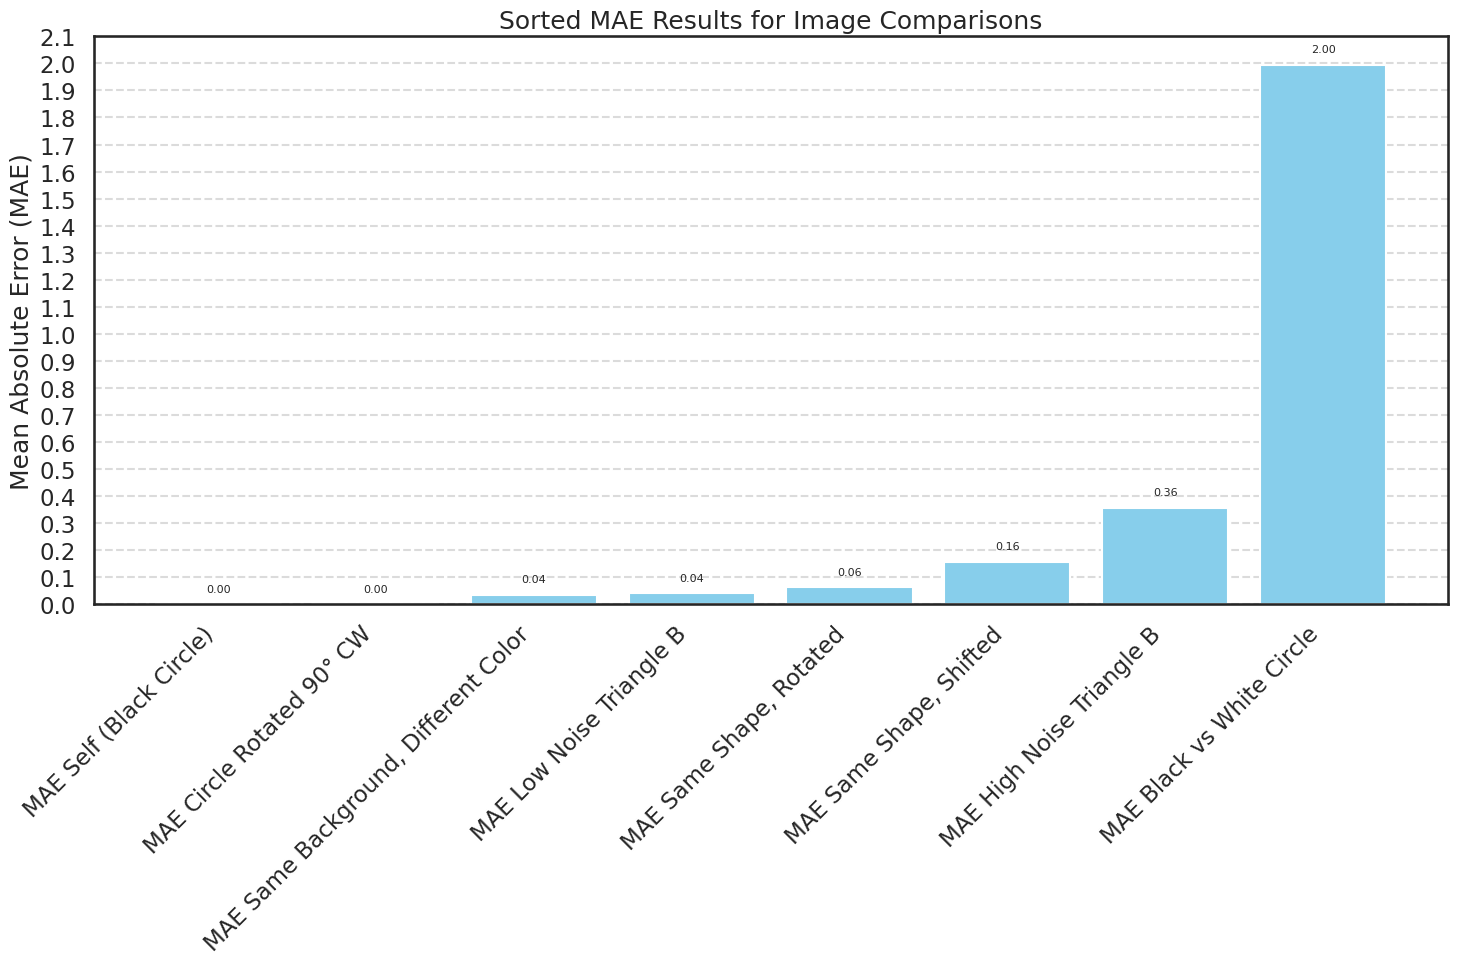

In [159]:
# Display MAE results in a bar chart
def display_mae_results(mae_results):
    # Sort the results by MAE value
    sorted_results = sorted(mae_results.items(), key=lambda y: y[1])
    
    # Extract labels and values
    names, values = zip(*sorted_results)
    
    # Create a vertical bar chart
    plt.figure(figsize=(15, 10))
    bars = plt.bar(names, values, color='skyblue')
    
    # Add MAE value on top of each bar with extra spacing
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.04, f"{value:.2f}",
                 ha='center', va='bottom', fontsize=8)
    
    # Axis labels and title
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Sorted MAE Results for Image Comparisons')
    
    # Set y-axis ticks and range
    max_val = max(values)
    plt.yticks(np.arange(0, round(max_val + 0.2, 1), 0.1))
    plt.ylim(0, round(max_val + 0.15, 1))  # Add extra margin to prevent overlap
    
    # Rotate x labels for readability
    plt.xticks(rotation=45, ha='right')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

display_mae_results({
    'MAE Self (Black Circle)': img1_self_mae,
    'MAE Circle Rotated 90° CW': img290_mae,
    'MAE Black vs White Circle': img1_mae,
    'MAE Same Background, Different Color': img_tri_RB_mae,
    'MAE Same Shape, Rotated': img_triB_mae,
    'MAE Same Shape, Shifted': img_triShift_mae,
    'MAE Low Noise Triangle B': noisy_img_triB_mae,
    'MAE High Noise Triangle B': noisy2_img_triB_mae
})

### SSIM

In [160]:
# SSIM Function
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_ssim(img1, img2):
    # Convert to NumPy and move channels last
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    
    # Ensure range is [0, 1] or [0, 255]
    data_range = img1_np.max() - img1_np.min()
    return ssim(img1_np, img2_np, channel_axis=2, data_range=data_range)


In [161]:
# SSIM computations
img1_self_ssim = compute_ssim(img1[0], img1[0])
print(f"SSIM of black circle img with itself: {img1_self_ssim:.4f}")

img290_ssim = compute_ssim(img190[0], img1[0])
print(f"SSIM between same circles one rotated 90° clockwise: {img290_ssim:.4f}")

img1_ssim = compute_ssim(img1[0], img2[0])
print(f"SSIM between black circle and white circle: {img1_ssim:.4f}")

img_tri_RB_ssim = compute_ssim(img_triB[0], img_triR[0])
print(f"SSIM between same background & triangle shape but different color: {img_tri_RB_ssim:.4f}")

img_triB_ssim = compute_ssim(img_triB[0], img_triB90[0])
print(f"SSIM between same triangle shape & color but rotated 90° clockwise: {img_triB_ssim:.4f}")

img_triShift_ssim = compute_ssim(img_triB[0], img_triShift[0])
print(f"SSIM between same triangle shape but shifted to right: {img_triShift_ssim:.4f}")

noisy_img_triB_ssim = compute_ssim(noisy1_img_triB[0], img_triB[0])
print(f"SSIM between low-noise triangle and original triangle B: {noisy_img_triB_ssim:.4f}")

noisy2_img_triB_ssim = compute_ssim(noisy2_img_triB[0], img_triB[0])
print(f"SSIM between high-noise triangle and original triangle B: {noisy2_img_triB_ssim:.4f}")


SSIM of black circle img with itself: 1.0000
SSIM between same circles one rotated 90° clockwise: 1.0000
SSIM between black circle and white circle: -0.9448
SSIM between same background & triangle shape but different color: 0.9652
SSIM between same triangle shape & color but rotated 90° clockwise: 0.9292
SSIM between same triangle shape but shifted to right: 0.8338
SSIM between low-noise triangle and original triangle B: 0.5338
SSIM between high-noise triangle and original triangle B: 0.0241


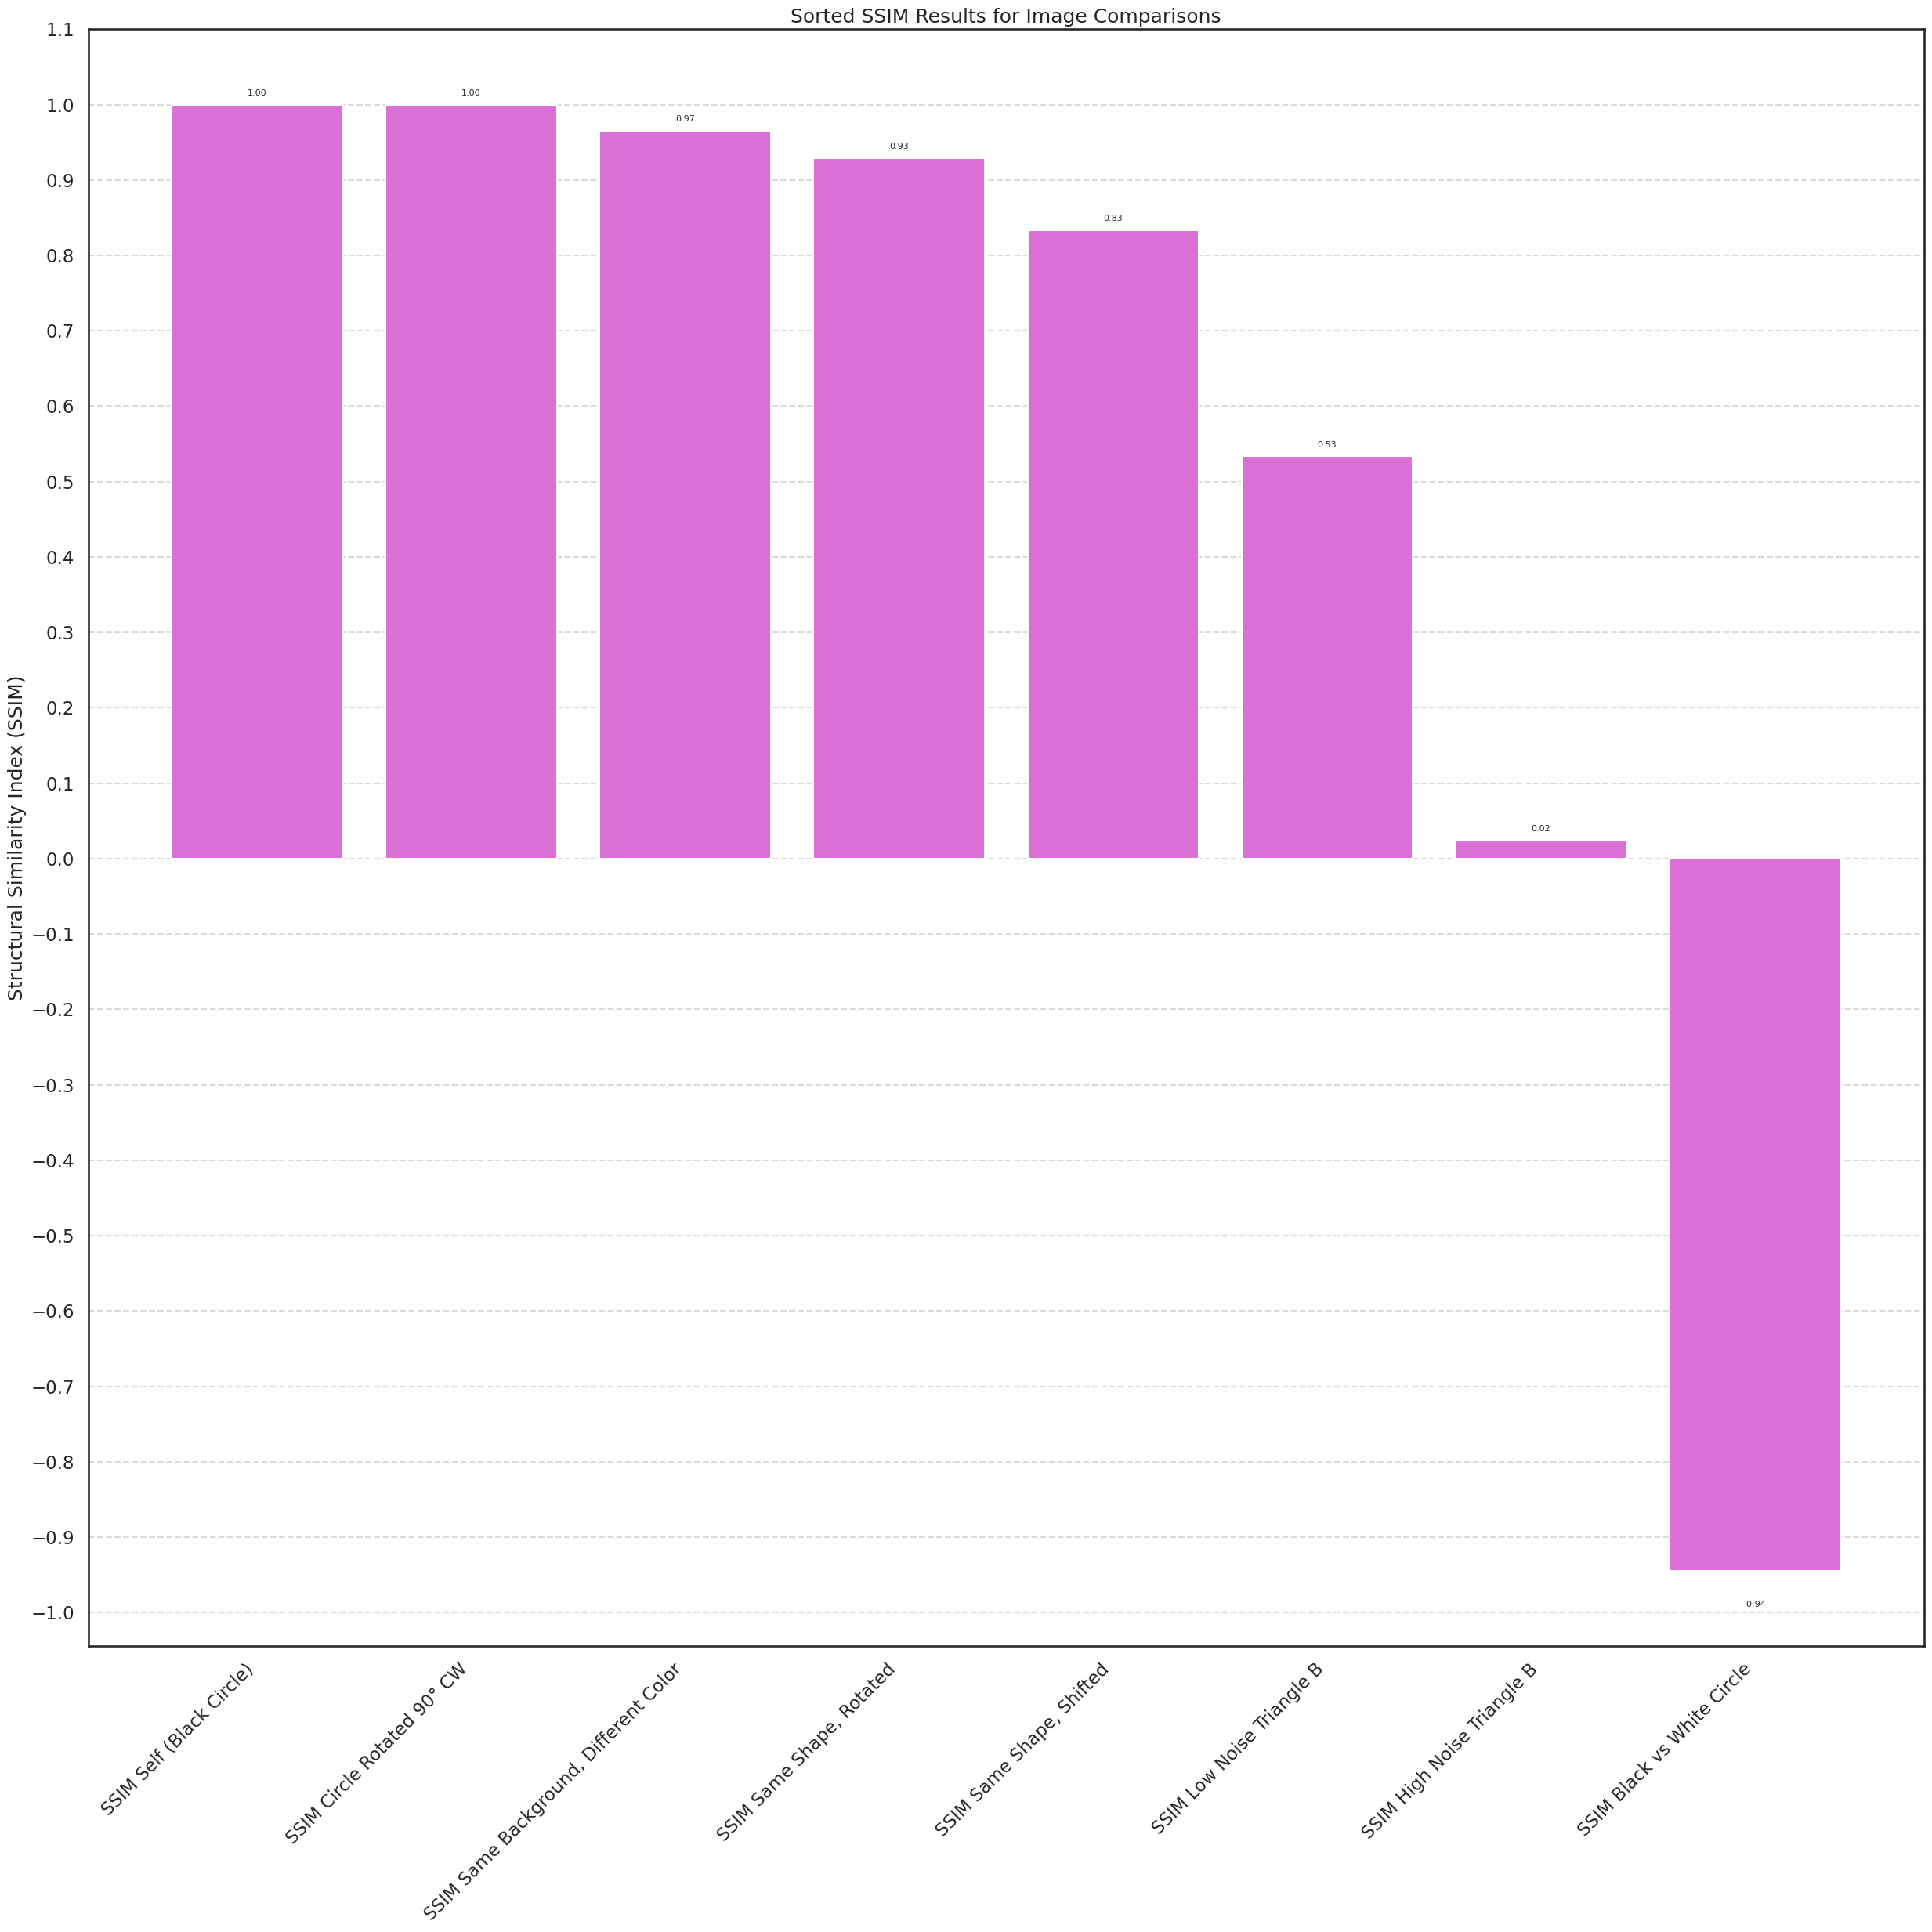

In [162]:
#Display results
def display_ssim_results(ssim_results):
    # Replace non-finite values (inf or nan) with max finite + 0.2
    finite_values = [v for v in ssim_results.values() if math.isfinite(v)]
    max_finite = max(finite_values) if finite_values else 0
    processed_results = {
        k: max_finite + 0.2 if not math.isfinite(v) else v
        for k, v in ssim_results.items()
    }

    # Sort by SSIM descending
    sorted_results = sorted(processed_results.items(), key=lambda x: x[1], reverse=True)
    names, values = zip(*sorted_results)

    # Plot
    plt.figure(figsize=(25, 25))
    bars = plt.bar(names, values, color='orchid')

    # Annotate
    for bar, value in zip(bars, values):
        original_value = ssim_results.get(bar.get_label(), value)
        label = "∞" if not math.isfinite(original_value) else f"{original_value:.2f}"
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01 if value >= 0 else value - 0.05,
                 label, ha='center', va='bottom', fontsize=8)

    # Axis
    plt.ylabel('Structural Similarity Index (SSIM)')
    plt.title('Sorted SSIM Results for Image Comparisons')
    y_min = min(values) - 0.1 if min(values) < 0 else 0
    y_max = max(values) + 0.1
    plt.ylim(y_min, y_max)
    plt.yticks(np.arange(round(y_min, 1), round(y_max + 0.1, 1), 0.1))
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

display_ssim_results({
    'SSIM Self (Black Circle)': img1_self_ssim,
    'SSIM Circle Rotated 90° CW': img290_ssim,
    'SSIM Black vs White Circle': img1_ssim,
    'SSIM Same Background, Different Color': img_tri_RB_ssim,
    'SSIM Same Shape, Rotated': img_triB_ssim,
    'SSIM Same Shape, Shifted': img_triShift_ssim,
    'SSIM Low Noise Triangle B': noisy_img_triB_ssim,
    'SSIM High Noise Triangle B': noisy2_img_triB_ssim
})

## MRI

Original shape of /home/nbelloula/GAI/Synthetic7TMRI/data/original/3T/sub-MS3T004_T1w_MNI152_ANTs.nii.gz: (182, 218, 182)
Shape after extracting slice: (218, 182)
Original shape of /home/nbelloula/GAI/Synthetic7TMRI/data/original/7T/sub-MS7T004_T1w_MNI152_ANTs.nii.gz: (182, 218, 182)
Shape after extracting slice: (218, 182)
Original shape of /home/nbelloula/GAI/Synthetic7TMRI/data/original/7T_synthetic/sub-MS3T004_T1w_MNI152_ANTs_pred.nii.gz: (182, 218, 182)
Shape after extracting slice: (218, 182)
3T Image Shape (after slice): (218, 182)
7T Real Image Shape (after slice): (218, 182)
7T Synth Image Shape (after slice): (218, 182)


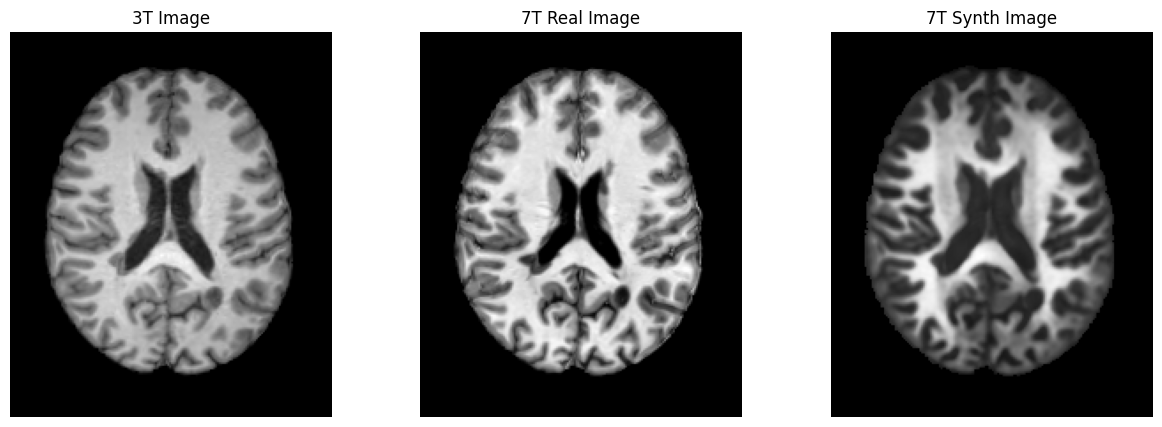

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nifti_slice(path, slice_idx=60):
    img = nib.load(path)
    data = img.get_fdata()
    print(f"Original shape of {path}: {data.shape}")  # Shape before slicing

    # slice_2d = data[:, :, slice_idx]
    slice_2d = data[:, :, data.shape[2] // 2]  # Middle slice
    slice_2d = np.rot90(slice_2d)  # Rotate for proper orientation

    print(f"Shape after extracting slice: {slice_2d.shape}")  # Shape after slicing

    return slice_2d / np.max(slice_2d)  # Normalize to [0, 1]

# Load images
img_3T = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/3T/sub-MS3T004_T1w_MNI152_ANTs.nii.gz')
img_7T_real = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/7T/sub-MS7T004_T1w_MNI152_ANTs.nii.gz')
img_7T_synth = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/7T_synthetic/sub-MS3T004_T1w_MNI152_ANTs_pred.nii.gz')

# Display shapes for confirmation
print(f"3T Image Shape (after slice): {img_3T.shape}")
print(f"7T Real Image Shape (after slice): {img_7T_real.shape}")
print(f"7T Synth Image Shape (after slice): {img_7T_synth.shape}")

# Display the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_3T, cmap='gray')
plt.title('3T Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_7T_real, cmap='gray')
plt.title('7T Real Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_7T_synth, cmap='gray')
plt.title('7T Synth Image')
plt.axis('off')
plt.show()


In [4]:
#compute metric separately for each image
def compute_ssim(img1, img2):
    return SSIM(img1, img2)
def compute_psnr(img1, img2):
    return PSNR(img1, img2)
def compute_mae(img1, img2):
    return mean_absolute_error(img1.flatten(), img2.flatten())
def compute_lpips(img1, img2):
    img1_tensor = torch.tensor(img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    img2_tensor = torch.tensor(img2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    loss_fn = lpips.LPIPS(net='alex')  # net='alex' or 'vgg'
    return loss_fn(img1_tensor, img2_tensor).item()
def compute_FID(img1, img2):
    fid = FrechetInceptionDistance(feature=64)
    fid.update(img1, real=True)
    fid.update(img2, real=False)
    fid_score = fid.compute()
    return fid_score

In [5]:
def compute_mae(img1, img2):
    return mean_absolute_error(img1.flatten(), img2.flatten())


In [6]:
def compute_ssim(img1, img2):
    ssim = SSIM(img1, img2, data_range=1.0)
    #format ssim to be between 0 and 1
    ssim = (ssim + 1) / 2  # Adjusting SSIM to be in the range [0, 1]
    return ssim


In [7]:
def compute_psnr(img1, img2):
    return PSNR(img1, img2, data_range=1.0)

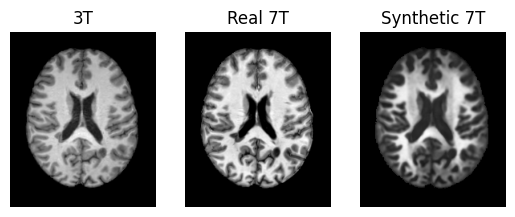

In [8]:
fig, axs = plt.subplots(1, 3)
titles = ['3T', 'Real 7T', 'Synthetic 7T']
for ax, img, title in zip(axs, [img_3T, img_7T_real, img_7T_synth], titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [9]:
#display images and metrics
# Compute metrics    
mae_3Tself = compute_mae(img_3T, img_3T)
mae_value37r = mean_absolute_error(img_3T, img_7T_real)
mae_values37s = mean_absolute_error(img_3T, img_7T_synth)
mae_values7r7s = mean_absolute_error(img_7T_real, img_7T_synth)

print(f"MAE (3T vs 3T): {mae_3Tself:.4f}")
print(f"MAE (3T vs real 7T): {mae_value37r:.4f}")
print(f"MAE (3T vs synthetic 7T): {mae_values37s:.4f}")
print(f"MAE (real 7T vs synthetic 7T): {mae_values7r7s:.4f}")


MAE (3T vs 3T): 0.0000
MAE (3T vs real 7T): 0.0564
MAE (3T vs synthetic 7T): 0.0740
MAE (real 7T vs synthetic 7T): 0.0965


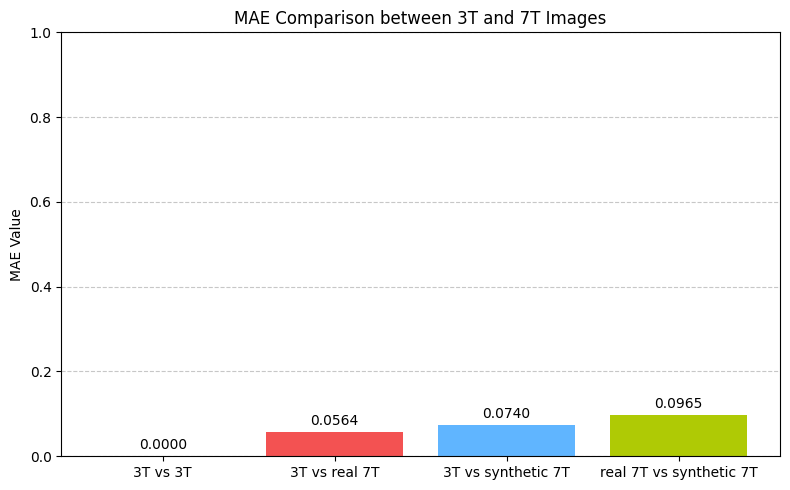

In [10]:
# Plotting the SSIM values in a bar chart
# MAE  values

mae_values = [mae_3Tself, mae_value37r, mae_values37s, mae_values7r7s]
# Labels for the comparisons
labels = [
    '3T vs 3T',
    '3T vs real 7T',
    '3T vs synthetic 7T',
    'real 7T vs synthetic 7T'
]

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, mae_values, color=['#ffe588', '#f35252', '#60b5ff', '#afca05'])

# Annotate bars with mae values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

# Customize chart
plt.ylabel('MAE Value')
plt.ylim(0, 1)
plt.title('MAE Comparison between 3T and 7T Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
ssim_value3Tself = compute_ssim(img_3T, img_3T)
ssim_value37r = compute_ssim(img_3T, img_7T_real)
ssim_values37s = compute_ssim(img_3T, img_7T_synth)
ssim_values7r7s = compute_ssim(img_7T_real, img_7T_synth)

print(f"SSIM (3T vs 3T): {ssim_value3Tself:.4f}")   
print(f"SSIM (3T vs real 7T): {ssim_value37r:.4f}")
print(f"SSIM (3T vs synthetic 7T): {ssim_values37s:.4f}")
print(f"SSIM (real 7T vs synthetic 7T): {ssim_values7r7s:.4f}")


SSIM (3T vs 3T): 1.0000
SSIM (3T vs real 7T): 0.9089
SSIM (3T vs synthetic 7T): 0.9174
SSIM (real 7T vs synthetic 7T): 0.8758


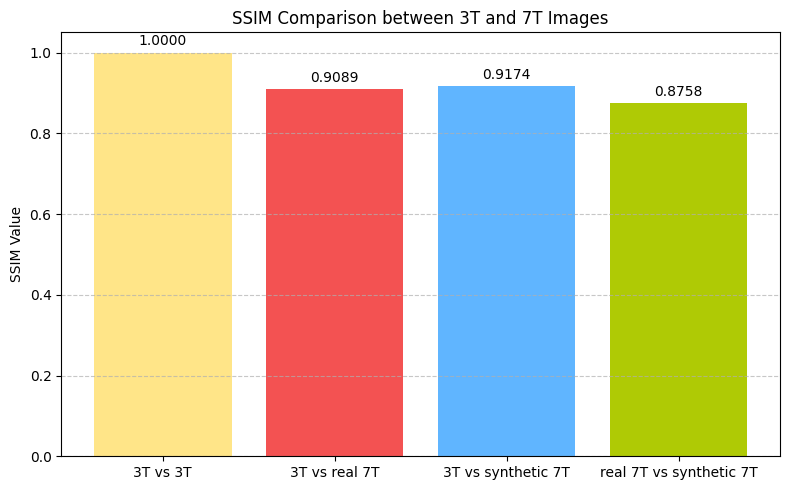

In [12]:
# Plotting the SSIM values in a bar chart
# SSIM values
ssim_values = [ssim_value3Tself, ssim_value37r, ssim_values37s, ssim_values7r7s]

# Labels for the comparisons
labels = [
    '3T vs 3T',
    '3T vs real 7T',
    '3T vs synthetic 7T',
    'real 7T vs synthetic 7T'
]

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ssim_values, color=['#ffe588', '#f35252', '#60b5ff', '#afca05'])

# Annotate bars with SSIM values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

# Customize chart
plt.ylabel('SSIM Value')
plt.ylim(0, 1.05)
plt.title('SSIM Comparison between 3T and 7T Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
psnr_value3Tself = compute_psnr(img_3T, img_3T)
psnr_value37r = compute_psnr(img_3T, img_7T_real)
psnr_values37s = compute_psnr(img_3T, img_7T_synth)
psnr_values7r7s = compute_psnr(img_7T_real, img_7T_synth)

print(f"PSNR (3T vs 3T): {psnr_value3Tself:.4f} dB")
print(f"PSNR (3T vs real 7T): {psnr_value37r:.4f} dB")
print(f"PSNR (3T vs synthetic 7T): {psnr_values37s:.4f} dB")
print(f"PSNR (real 7T vs synthetic 7T): {psnr_values7r7s:.4f} dB")

PSNR (3T vs 3T): inf dB
PSNR (3T vs real 7T): 20.1690 dB
PSNR (3T vs synthetic 7T): 18.2901 dB
PSNR (real 7T vs synthetic 7T): 15.6618 dB


/home/nbelloula/GAI/.venv/lib/python3.12/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


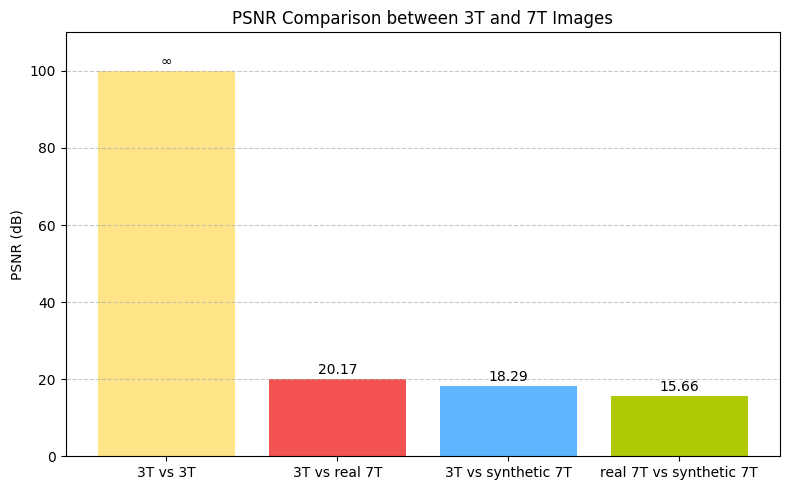

In [29]:
# Replace infinity with a high number
if psnr_value3Tself == float('inf'):
    psnr_value3Tself = 120 # Adjust this value as needed

psnr_values = [
    psnr_value3Tself,
    psnr_value37r,
    psnr_values37s,
    psnr_values7r7s
]

labels = [
    '3T vs 3T',
    '3T vs real 7T',
    '3T vs synthetic 7T',
    'real 7T vs synthetic 7T'
]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, psnr_values, color=['#ffe588', '#f35252', '#60b5ff', '#afca05'])

# Annotate bars with special handling for infinity
for bar in bars:
    height = bar.get_height()
    label = '∞' if height == 100 else f'{height:.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, label, ha='center', va='bottom')

# Customize chart
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparison between 3T and 7T Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(psnr_values) * 1.1)  # Add some headroom

plt.tight_layout()
plt.show()

In [20]:
import torch
import lpips
import numpy as np

def prepare_for_lpips(img):
    # Ensure shape is (H, W) → (1, 1, H, W)
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Repeat the single channel 3 times → (1, 3, H, W)
    img_tensor = img_tensor.repeat(1, 3, 1, 1)
    
    # Normalize to [-1, 1]
    img_tensor = img_tensor * 2 - 1
    return img_tensor

# Prepare the images
img_3T_LPIPS = prepare_for_lpips(img_3T)
img_7T_real_LPIPS = prepare_for_lpips(img_7T_real)
img_7T_synth_LPIPS = prepare_for_lpips(img_7T_synth)

 

# Initialize the LPIPS model
lpips_model = lpips.LPIPS(net='vgg')  # or 'vgg'
lpips_modelAlex= lpips.LPIPS(net='alex') 

# Compute LPIPS score
lpips_score = lpips_model(img_3T_LPIPS, img_7T_synth_LPIPS)
lpips_score_alex = lpips_modelAlex(img_3T_LPIPS, img_7T_synth_LPIPS)
print(f"LPIPS (3T vs Synth7T, VGG): {lpips_score.item():.4f}")
print(f"LPIPS (3T vs Synth7T, Alex): {lpips_score_alex.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/nbelloula/GAI/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nbelloula/GAI/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/nbelloula/GAI/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/nbelloula/GAI/.venv/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loca

Loading model from: /home/nbelloula/GAI/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
LPIPS (3T vs Synth7T, VGG): 0.1227
LPIPS (3T vs Synth7T, Alex): 0.1462


## Annexe


/tmp/ipykernel_7774/3460769840.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels, y=maes, palette="rocket")
/tmp/ipykernel_7774/3460769840.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


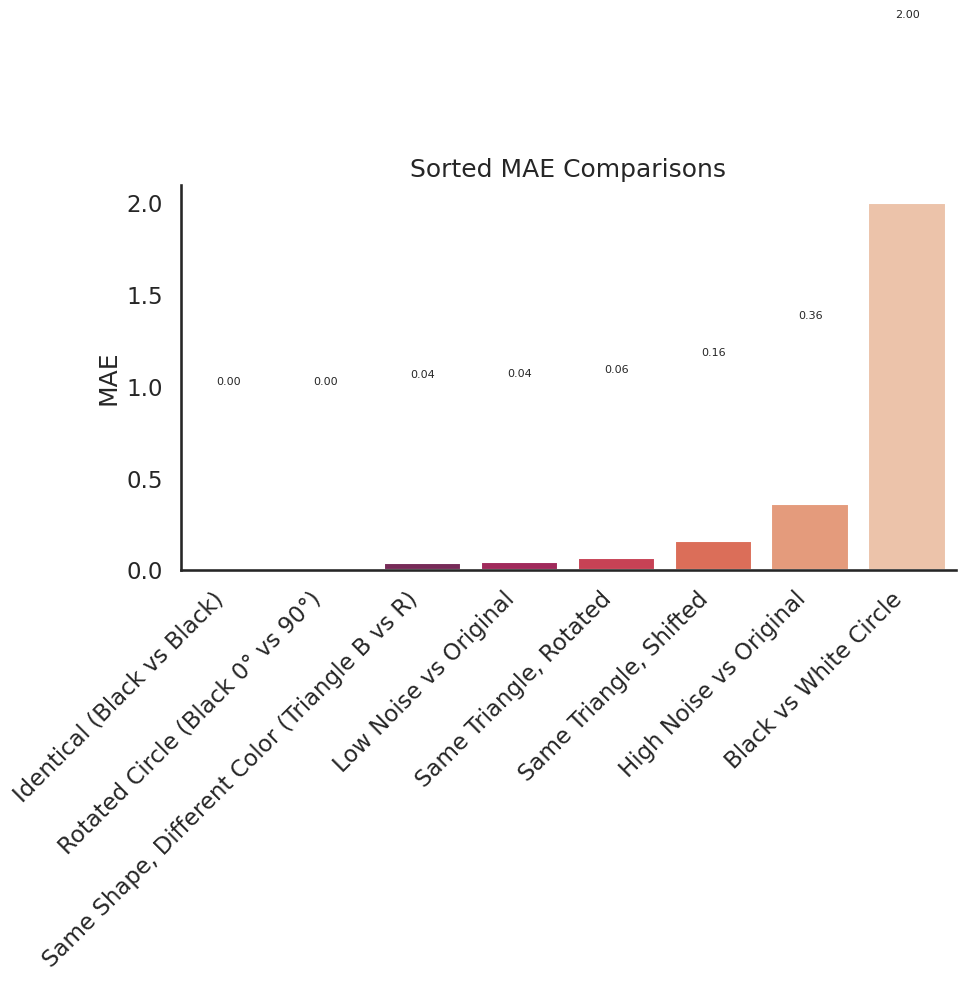

In [104]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_theme(style="white", context="talk")

# # Define MAE comparisons
# mae_values = {
#     "Identical (Black vs Black)": compute_mae(img1[0], img1[0]),
#     "Rotated Circle (Black 0° vs 90°)": compute_mae(img190[0], img1[0]),
#     "Black vs White Circle": compute_mae(img1[0], img2[0]),
#     "Same Shape, Different Color (Triangle B vs R)": compute_mae(img_triB[0], img_triR[0]),
#     "Same Triangle, Rotated": compute_mae(img_triB[0], img_triB90[0]),
#     "Same Triangle, Shifted": compute_mae(img_triB[0], img_triShift[0]),
#     "Low Noise vs Original": compute_mae(noisy1_img_triB[0], img_triB[0]),
#     "High Noise vs Original": compute_mae(noisy2_img_triB[0], img_triB[0]),
# }

# # Sort by MAE
# sorted_items = sorted(mae_values.items(), key=lambda item: item[1])
# labels, maes = zip(*sorted_items)

# # Set up figure
# plt.figure(figsize=(10, 5))
# barplot = sns.barplot(x=labels, y=maes, palette="rocket")

# # Add MAE labels above bars
# for i, (label, mae) in enumerate(sorted_items):
#     plt.text(i, mae+1 , f"{mae:.2f}", ha='center', va='bottom', fontsize=8)

# plt.ylabel("MAE")
# plt.title("Sorted MAE Comparisons")
# plt.xticks(rotation=45, ha='right')

# # Set y-axis from 0 to 2 with 0.2 steps
# # plt.yticks(np.arange(0, 4, 0.2))
# # plt.ylim(0, 2)

# plt.tight_layout()
# sns.despine()
# plt.show()


In [ ]:
lpips_model = lpips.LPIPS(net='alex', pretrained=True)  # Load the LPIPS model with AlexNet backbone
lpips_model.eval() # important to set the model to evaluation mode because LPIPS uses batch normalization and dropout layers which behave differently during training and evaluation
# Expected input shape for LPIPS is (N, C, H, W) 
# Convert images to 3-channel format for LPIPS
new_shape = (img_3T.shape[0], img_3T.shape[1], 1)  # Assuming img_3T is a 2D image
img_3T = img_3T.reshape(new_shape)
print(f"3T Image Reshaped: {img_3T.shape}")

# # load image not as a single channel but as a 3-channel image for lpips 
# # img_3Tvol = np.stack([img_3T]*3, axis=-1)  # Convert to 3-channel image
# # img_7T_synthvol = np.stack([img_7T_synth]*3, axis=-1)  # Convert to 3-channel image

# img_3T_LPIPS = np.repeat(img_3T[:, :, np.newaxis], 3, axis=2)

# #print shape of the image
# imgshape= img_3T_LPIPS.shape
# print

# img_7T_synth_LPIPS = np.repeat(img_7T_synth[:, :, np.newaxis], 3, axis=2)

# print(f"Image Shape: {img_3T_LPIPS.shape}") 


# def to_tensor(img):
#     transform = T.Compose([
#         T.ToPILImage(),
#         #T.Resize((256, 256)), 
#         T.ToTensor(),
#         T.Normalize([0.5], [0.5])
#     ])
#     return transform(np.stack([img]*3)).unsqueeze(0)

# img_3T_tensor = to_tensor(img_3T_LPIPS)
# img_7T_tensor = to_tensor(img_7T_synth_LPIPS)

# lpips_score = lpips_model(img_3T_tensor, img_7T_tensor).item()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nbelloula/GAI/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
3T Image Reshaped: (218, 182, 1)
